In [0]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import csv

import keras.utils as K
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPool2D,BatchNormalization, UpSampling2D, Dropout, Dense, Reshape
from keras.layers import Conv2DTranspose, Flatten, Add, Concatenate, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip gdrive/My\ Drive/ComicDataset.zip

Archive:  gdrive/My Drive/ComicDataset.zip
   creating: ComicDataset/Test/
   creating: ComicDataset/Test/Black/
  inflating: ComicDataset/Test/Black/10.png  
  inflating: ComicDataset/Test/Black/100.png  
  inflating: ComicDataset/Test/Black/107.png  
  inflating: ComicDataset/Test/Black/115.png  
  inflating: ComicDataset/Test/Black/133.png  
  inflating: ComicDataset/Test/Black/14.png  
  inflating: ComicDataset/Test/Black/141.png  
  inflating: ComicDataset/Test/Black/151.png  
  inflating: ComicDataset/Test/Black/152.png  
  inflating: ComicDataset/Test/Black/156.png  
  inflating: ComicDataset/Test/Black/162.png  
  inflating: ComicDataset/Test/Black/166.png  
  inflating: ComicDataset/Test/Black/168.png  
  inflating: ComicDataset/Test/Black/181.png  
  inflating: ComicDataset/Test/Black/191.png  
  inflating: ComicDataset/Test/Black/193.png  
  inflating: ComicDataset/Test/Black/196.png  
  inflating: ComicDataset/Test/Black/197.png  
  inflating: ComicDataset/Test/Black/198.pn

In [0]:
def formatColorImage(img):
    img = img.convert('RGB')
    return np.array(img.resize((768, 1152), Image.ANTIALIAS), 'float32')/127.5 - 1

def formatBlackImage(img):
    return np.array(img.resize((768, 1152), Image.ANTIALIAS), 'float32').reshape(1152,768,1)/127.5-1

def getImages(colorImagePath, greyImagePath):
    images = {}
    i, j = 0, 0
    for fileName in os.listdir(colorImagePath):
        file = os.path.join(colorImagePath,fileName)
        img = Image.open(file)
        if(img.mode == 'RGB'):
            images[fileName[:-4]] = [np.array(img.resize((768, 1152), Image.ANTIALIAS), 'float32')/127.5 - 1]
            i += 1
            
    for fileName in os.listdir(greyImagePath):
        file = os.path.join(greyImagePath, fileName)
        img = Image.open(file)
        if(fileName[:-4] in images):
            images[fileName[:-4]].append(np.array(img.resize((768, 1152), Image.ANTIALIAS), 'float32').reshape(1152,768,1)/127.5-1)
            j += 1
    print(i, j)
    return images

In [0]:
def data_gen(Set, batch_size):
    while(True):
        keys = np.random.choice(list(Set.keys()), batch_size)
        gImg, cImg = [], []
        for k in keys:
            cImg.append(Set[k][0])
            gImg.append(Set[k][1])
        yield np.array(gImg), np.array(cImg)

In [0]:
%%time
imageSet = getImages("ComicDataset/Train/ColorImages", "ComicDataset/Train/Black")

458 458
CPU times: user 35.8 s, sys: 1.98 s, total: 37.8 s
Wall time: 37.8 s


1 1152 768
1 1152 768 3
1 1152 768
1 1152 768 3
CPU times: user 86.5 ms, sys: 19.1 ms, total: 106 ms
Wall time: 115 ms


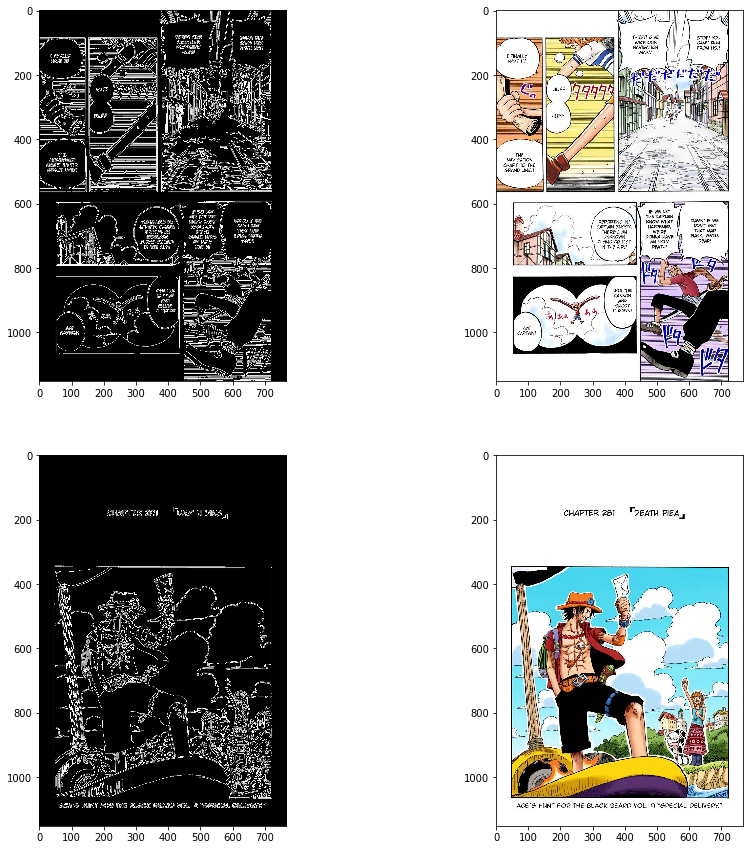

In [0]:
%%time
_, axs = plt.subplots(2, 2, figsize=(15, 15))
for i, d in enumerate(data_gen(imageSet, 1)):
    _, h0, w0, c0 = d[0].shape
    _, h1, w1, c1 = d[1].shape
    print(_, h0, w0)
    print(_, h1, w1, c1)
    gImg = d[0].reshape(h0, w0) * 0.5 + 0.5
    cImg = d[1].reshape(h1, w1, c1) * 0.5 + 0.5
    axs[i][0].imshow(gImg, cmap='Greys_r')
    axs[i][1].imshow(cImg)
    if(i == 1):
        break

In [0]:
def generator():
    inp_img = Input((1152, 768, 1))
    
    # DownSampling
    lay_1 = Conv2D(64, 5, padding='same', name='block1_conv')(inp_img)
    lay_1 = LeakyReLU(alpha=0.2)(lay_1)
    max_1 = MaxPool2D(name='block1_pool')(lay_1)
    
    lay_2 = Conv2D(128, 3, padding='same', name='block2_conv')(max_1)
    lay_2 = LeakyReLU(alpha=0.2)(lay_2)
    dout_2 = Dropout(0.1, name='block2_dropout')(lay_2)
    max_2 = MaxPool2D(name='block2_pool')(dout_2)
    bat_2 = BatchNormalization(name='block2_batchNorm')(max_2)
    
    lay_3 = Conv2D(128, 3, padding='same', name='block3_conv')(bat_2)
    lay_3 = LeakyReLU(alpha=0.2)(lay_3)
    dout_3 = Dropout(0.1, name='block3_dropout')(lay_3)
    max_3 = MaxPool2D(name='block3_pool')(dout_3)
    bat_3 = BatchNormalization(name='block3_batchNorm')(max_3)
    
    lay_4 = Conv2D(256, 3, padding='same', name='block4_conv')(bat_3)
    lay_4 = LeakyReLU(alpha=0.2)(lay_4)    
    dout_4 = Dropout(0.1, name='block4_dropout')(lay_4)
    max_4 = MaxPool2D(name='block4_pool')(dout_4)
    bat_4 = BatchNormalization(name='block4_batchNorm')(max_4)
    
    lay_5 = Conv2D(256, 3, padding='same', name='block5_conv')(bat_4)
    lay_5 = LeakyReLU(alpha=0.2)(lay_5)
    dout_5 = Dropout(0.1, name='block5_dropout')(lay_5)
    max_5 = MaxPool2D(name='block5_pool')(dout_5)
    bat_5 = BatchNormalization(name='block5_batchNorm')(max_5)
    
    lay_6 = Conv2D(512, 3, padding='same', name='block6_conv')(bat_5)
    lay_6 = LeakyReLU(alpha=0.2)(lay_6)    
    dout_6 = Dropout(0.1, name='block6_dropout')(lay_6)
    max_6 = MaxPool2D(name='block6_pool')(dout_6)
    bat_6 = BatchNormalization(name='block6_batchNorm')(max_6)
    
    lay_7 = Conv2D(1024, 3, padding='same', name='block7_conv')(bat_6)
    lay_7 = LeakyReLU(alpha=0.2)(lay_7)
    
    #UpSampling
    upS_8 = Conv2DTranspose(256, 3, strides=2, padding='same', name='block8_convTranspose')(lay_7)
    upS_8 = LeakyReLU(alpha=0.2)(upS_8)
    bat_8 = BatchNormalization(name='block8_batchNorm')(upS_8)
    con_8 = Concatenate(name='block8_concat')([bat_8, max_5])
    
    upS_9 = Conv2DTranspose(256, 3, strides=2, padding='same', name='block9_convTranspose')(con_8)
    upS_9 = LeakyReLU(alpha=0.2)(upS_9)
    bat_9 = BatchNormalization(name='block9_batchNorm')(upS_9)
    con_9 = Concatenate(name='block9_concat')([bat_9, max_4])
    
    upS_10 = Conv2DTranspose(128, 3, strides=2, padding='same', name='block10_convTranspose')(con_9)
    upS_10 = LeakyReLU(alpha=0.2)(upS_10)
    bat_10 = BatchNormalization(name='block10_batchNorm')(upS_10)
    con_10 = Concatenate(name='block10_concat')([bat_10, max_3])
    
    upS_11 = Conv2DTranspose(128, 3, strides=2, padding='same', name='block11_convTranspose')(con_10)
    upS_11 = LeakyReLU(alpha=0.2)(upS_11)
    bat_11 = BatchNormalization(name='block11_batchNorm')(upS_11)
    con_11 = Concatenate(axis=-1, name='block11_concat')([bat_11, max_2])
    
    upS_12 = Conv2DTranspose(64, 3, strides=2, padding='same', name='block12_convTranspose')(con_11)
    upS_12 = LeakyReLU(alpha=0.2)(upS_12)
    bat_12 = BatchNormalization(name='block12_batchNorm')(upS_12)
    con_12 = Concatenate(axis=-1, name='block12_concat')([bat_12, max_1])
    
    out = Conv2DTranspose(3, 3, strides=2, activation='tanh', padding='same',  name='block13_convTranspose')(con_12)
    return Model(inp_img, out)

In [0]:
def discriminator():
    img_A = Input((1152, 768, 1))
    img_B = Input((1152, 768, 3))
    
    lay_1_A = Conv2D(3, 3, padding='same', name='block1_conv_A')(img_A)
    lay_1_A = LeakyReLU(alpha=0.2)(lay_1_A)    
    lay_1_B = Conv2D(3, 3, padding='same', name='block1_conv_B')(img_B)
    lay_1_B = LeakyReLU(alpha=0.2)(lay_1_B)
    con_2 = Concatenate(axis=-1, name='block1_concat')([lay_1_A, lay_1_B])
    
    lay_2 = Conv2D(64, 3, padding='same', name='block2_conv')(con_2)
    lay_2 = LeakyReLU(alpha=0.2)(lay_2)    
    max_2 = MaxPool2D(name='block2_pool')(lay_2)
    bat_2 = BatchNormalization(name='block2_batchNorm')(max_2)
    
    lay_3 = Conv2D(128, 3, padding='same', name='block3_conv')(bat_2)
    lay_3 = LeakyReLU(alpha=0.2)(lay_3)
    max_3 = MaxPool2D(name='block3_pool')(lay_3)
    bat_3 = BatchNormalization(name='block3_batchNorm')(max_3)
    
    lay_4 = Conv2D(128, 3, padding='same', name='block4_conv')(bat_3)
    lay_4 = LeakyReLU(alpha=0.2)(lay_4)    
    max_4 = MaxPool2D(name='block4_pool')(lay_4)
    bat_4 = BatchNormalization(name='block4_batchNorm')(max_4)
    
    lay_5 = Conv2D(256, 3, padding='same', name='block5_conv')(bat_4)
    lay_5 = LeakyReLU(alpha=0.2)(lay_5)
    max_5 = MaxPool2D(name='block5_pool')(lay_5)
    bat_5 = BatchNormalization(name='block5_batchNorm')(max_5)
    
    lay_6 = Conv2D(256, 3, padding='same', name='block6_conv')(bat_5)
    lay_6 = LeakyReLU(alpha=0.2)(lay_6)
    max_6 = MaxPool2D(name='block6_pool')(lay_6)
    bat_6 = BatchNormalization(name='block6_batchNorm')(max_6)
    
    lay_7 = Conv2D(256, 3, padding='same', name='block7_conv')(bat_6)
    lay_7 = LeakyReLU(alpha=0.2)(lay_7)
    max_7 = MaxPool2D(name='block7_pool')(lay_7)
    bat_7 = BatchNormalization(name='block7_batchNorm')(max_7)
    validity = Conv2D(1, 1, activation='sigmoid', padding='same', name='block8_conv')(bat_7)
    return Model([img_A, img_B], validity)

In [0]:
def cGAN(gen, dis):    
    grey_img = Input((1152, 768,1))
    color_img = Input((1152, 768,3))

    generated_img = gen(grey_img)

    dis.trainable = False

    validity = dis([grey_img, generated_img])
    
    cgan = Model(inputs=[grey_img], outputs=[validity, generated_img])
    return cgan

In [0]:
gen = generator()
gen.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.







Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1152, 768, 1) 0                                            
__________________________________________________________________________________________________
block1_conv (Conv2D)            (None, 1152, 768, 64 1664        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 1152, 768, 64 0           block1_conv[0][0]                
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 576, 384, 64) 0          

In [0]:
dis = discriminator()
dis.summary()
dis.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1152, 768, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1152, 768, 3) 0                                            
__________________________________________________________________________________________________
block1_conv_A (Conv2D)          (None, 1152, 768, 3) 30          input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv_B (Conv2D)          (None, 1152, 768, 3) 84          input_3[0][0]                    
____________________________________________________________________________________________

In [0]:
combined_model = cGAN(gen, dis)
combined_model.summary()
combined_model.compile(loss={'model_2':'binary_crossentropy', 'model_1':'mse'}, optimizer=Adam(5e-4), metrics=['accuracy'], loss_weights={'model_2':0.1, 'model_1':1})

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1152, 768, 1) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1152, 768, 3) 11592003    input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 18, 12, 1)    1705011     input_4[0][0]                    
                                                                 model_1[1][0]                    
Total params: 13,297,014
Trainable params: 11,587,779
Non-trainable params: 1,709,235
__________________________________________________________________________________________________


In [0]:
def getImageSet(colorPath, blackPath, names):
    gList = []
    cList = []
    for name in names:
        imCpath = os.path.join(colorPath,name)
        imGpath = os.path.join(blackPath,name)
        imgC = Image.open(imCpath)
        imgG = Image.open(imGpath)
        gList.append(formatBlackImage(imgG))
        cList.append(formatColorImage(imgC))
    return np.array(gList), np.array(cList)
  
def saveAndPlotImage(t_cimg, t_gimg, gen, path):
    h, w, c = t_cimg.shape
    fake_A = gen.predict(t_gimg.reshape(1,1152,768,1))
    fake_A = 0.5 * fake_A + 0.5
    plt.imsave(path, fake_A.reshape(h, w, c))

In [0]:
from keras.models import load_model
gen = load_model('gdrive/My Drive/Comic Colorization/generator.h5')
dis = load_model('gdrive/My Drive/Comic Colorization/discriminator.h5')
combined_model = load_model('gdrive/My Drive/Comic Colorization/combined_model.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
%%time
batch_size = 3
iteration = 128
epoch = 10
patch_i = 18
patch_j = 12
discriminatorLoss, generatorLoss = [], []
discriminatorAccuracy, generatorAccuracy = [], []

trainSet = getImageSet("ComicDataset/Train/ColorImages", "ComicDataset/Train/Black",['45.png', '416.png'])
testSet = getImageSet("ComicDataset/Test/ColorImages", "ComicDataset/Test/Black",['237.png', '441.png'])

patch_ones = np.ones((batch_size, patch_i, patch_j, 1))
patch_zeros = np.zeros((batch_size, patch_i, patch_j, 1))
for e in range(epoch):
    for i, d in enumerate(data_gen(imageSet, batch_size)):
        gImg, cImg = d[0], d[1]
        
        r = np.random.rand(1)
        if(r > 0.95):
            real = patch_zeros
            fake = patch_ones
        else:
            real = patch_ones
            fake = patch_zeros
        
        genImg = gen.predict(gImg)

        dis_loss_1 = dis.train_on_batch([gImg, cImg], real)
        dis_loss_2 = dis.train_on_batch([gImg, genImg], fake)
        dis_loss = 0.5 * np.add(dis_loss_1, dis_loss_2)

        discriminatorLoss.append(dis_loss[0])
        discriminatorAccuracy.append(100*dis_loss[1])
        
        cgan_loss = combined_model.train_on_batch([gImg], [patch_ones, cImg])
        
        generatorLoss.append(cgan_loss[2])
        generatorAccuracy.append(100*cgan_loss[4])
        
        if(i%10 == 0):
          print("Epoch %d/%d   iteration %d/%d  D Acc %3d%%  D Loss: %f  cGAN_Gen Acc: %3d%%  cGAN_Gen Loss: %f  cGAN_Dis Acc: %3d%%  cGAN_Dis Loss: %f  cGAN Total Loss %f" % (e, epoch, i, iteration, 100*dis_loss[1], dis_loss[0], 100*cgan_loss[4], cgan_loss[2], cgan_loss[3], cgan_loss[1], cgan_loss[0]))
        
        if(i == iteration-1):
          break    
    if ((e+1) % 2 == 0):
        rpath = 'gdrive/My Drive/Comic Colorization/results/'
        for i, img in enumerate(zip(trainSet[0],trainSet[1])):
          p = rpath + 'Train/{}_{}_result.png'.format(e,i)
          saveAndPlotImage(img[1], img[0], gen, p)
        for i, img in enumerate(zip(testSet[0],testSet[1])):
          p = rpath + 'Test/{}_{}_result.png'.format(e,i)
          saveAndPlotImage(img[1], img[0], gen, p)
        with open('gdrive/My Drive/Comic Colorization/discriminatorLossFile.csv', mode='a') as discriminatorLossFile:
          discriminatorLossFile_writer = csv.writer(discriminatorLossFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
          discriminatorLossFile_writer.writerow(discriminatorLoss)
          discriminatorLoss = []
        with open('gdrive/My Drive/Comic Colorization/GenLossFile.csv', mode='a') as DCGanLossFile:
          DCGanLossFile_writer = csv.writer(DCGanLossFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
          DCGanLossFile_writer.writerow(generatorLoss)
          generatorLoss = []
        gen.save('gdrive/My Drive/Comic Colorization/generator.h5')
        dis.save('gdrive/My Drive/Comic Colorization/discriminator.h5')
        combined_model.save('gdrive/My Drive/Comic Colorization/combined_model.h5')

Epoch 0/10   iteration 0/128  D Acc  48%  D Loss: 0.693175  cGAN_Gen Acc:  64%  cGAN_Gen Loss: 0.042250  cGAN_Dis Acc:   1%  cGAN_Dis Loss: 0.001263  cGAN Total Loss 0.042377
Epoch 0/10   iteration 10/128  D Acc  50%  D Loss: 0.693169  cGAN_Gen Acc:  59%  cGAN_Gen Loss: 0.053927  cGAN_Dis Acc:   1%  cGAN_Dis Loss: 0.001238  cGAN Total Loss 0.054051
Epoch 0/10   iteration 20/128  D Acc  52%  D Loss: 0.693169  cGAN_Gen Acc:  63%  cGAN_Gen Loss: 0.043817  cGAN_Dis Acc:   1%  cGAN_Dis Loss: 0.001213  cGAN Total Loss 0.043938
Epoch 0/10   iteration 30/128  D Acc  47%  D Loss: 0.693177  cGAN_Gen Acc:  67%  cGAN_Gen Loss: 0.042759  cGAN_Dis Acc:   1%  cGAN_Dis Loss: 0.001190  cGAN Total Loss 0.042878
Epoch 0/10   iteration 40/128  D Acc  52%  D Loss: 0.693169  cGAN_Gen Acc:  48%  cGAN_Gen Loss: 0.050497  cGAN_Dis Acc:   1%  cGAN_Dis Loss: 0.001166  cGAN Total Loss 0.050614
Epoch 0/10   iteration 50/128  D Acc  55%  D Loss: 0.693168  cGAN_Gen Acc:  58%  cGAN_Gen Loss: 0.059369  cGAN_Dis Acc:  

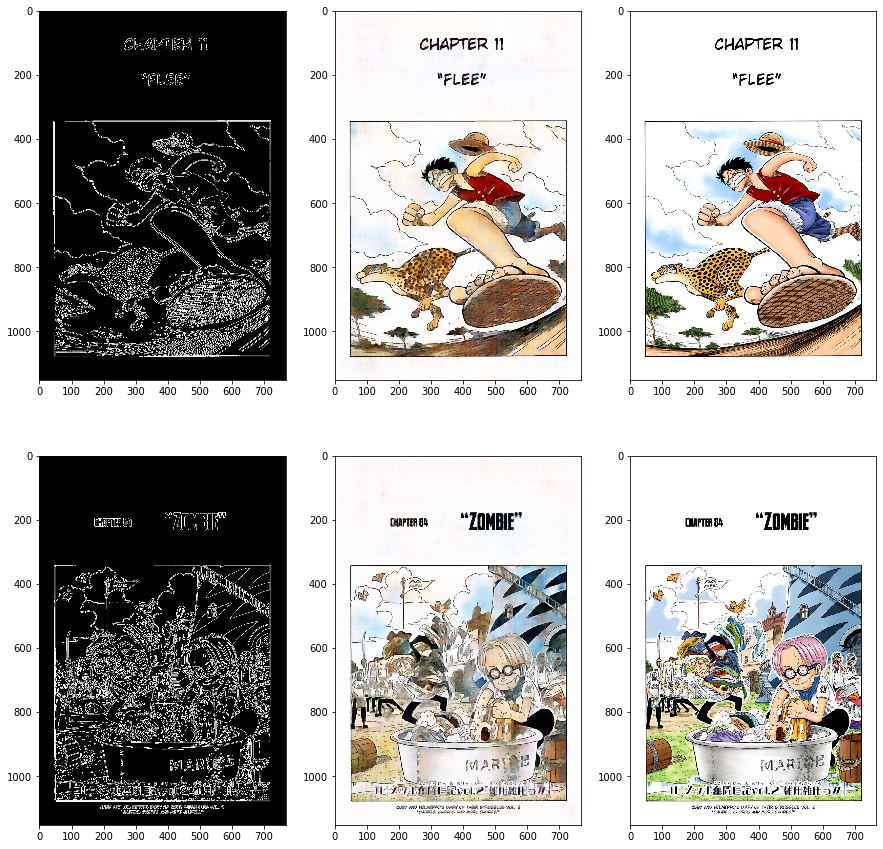

In [0]:
_, axs = plt.subplots(2, 3, figsize=(15, 15))
for i, d in enumerate(data_gen(imageSet, 1)):
    fake_A = gen.predict(d[0])
    _, h, w, c = d[1].shape
    
    gImg = d[0].reshape(h, w) * 0.5 + 0.5
    fake_A = fake_A * 0.5 + 0.5
    cImg = d[1].reshape(h, w, c) * 0.5 + 0.5
    axs[i][0].imshow(gImg.reshape(h, w), cmap='Greys_r')
    axs[i][1].imshow(fake_A.reshape(h, w, c))
    axs[i][2].imshow(cImg.reshape(h, w, c))
    
    if(i == 1):
        break

In [0]:
testSet = getImages("ComicDataset/Test/ColorImages", "ComicDataset/Test/Black")

120 120


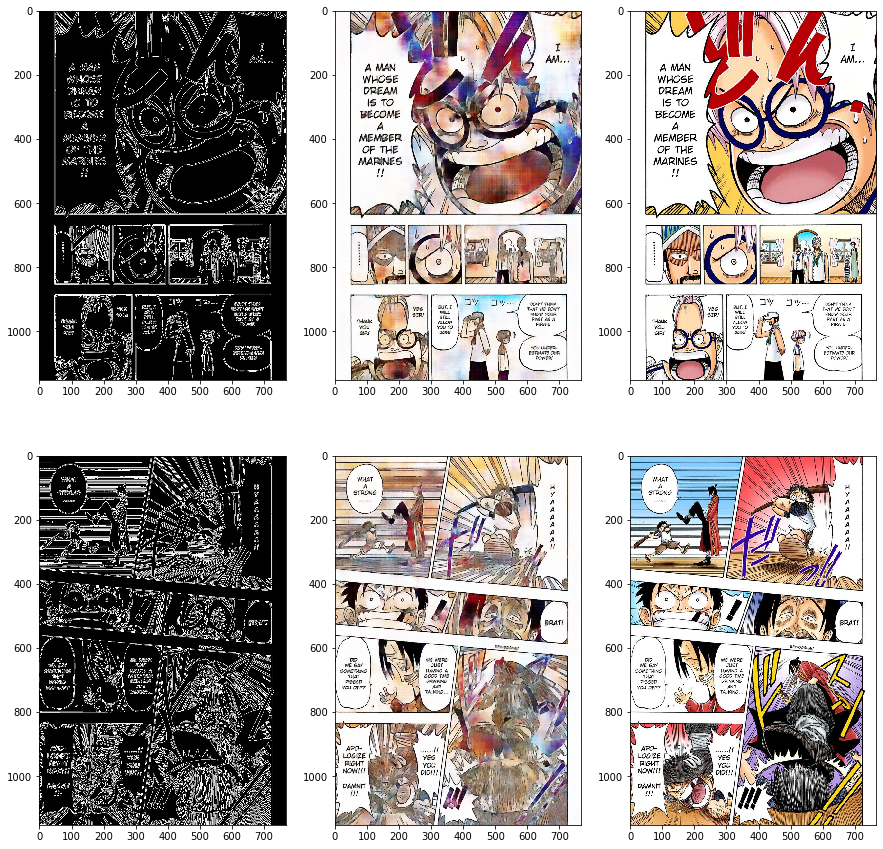

In [0]:
_, axs = plt.subplots(2, 3, figsize=(15, 15))
for i, d in enumerate(data_gen(testSet, 1)):
    fake_A = gen.predict(d[0])
    _, h, w, c = d[1].shape
    
    gImg = d[0].reshape(h, w) * 0.5 + 0.5
    fake_A = fake_A * 0.5 + 0.5
    cImg = d[1].reshape(h, w, c) * 0.5 + 0.5
    axs[i][0].imshow(gImg.reshape(h, w), cmap='Greys_r')
    axs[i][1].imshow(fake_A.reshape(h, w, c))
    axs[i][2].imshow(cImg.reshape(h, w, c))
    
    if(i == 1):
        break

In [0]:
gen.save('gdrive/My Drive/CCgenerator.h5')

In [0]:
dis.save('gdrive/My Drive/CCdiscriminator.h5')

In [0]:
combined_model.save('gdrive/My Drive/CCcombined_model.h5')

In [0]:
plt.plot(loss_1)
plt.plot(loss_2)
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['binary_crossentropy loss', 'binary_crossentropy+L2'], loc='upper right')
plt.show()
plt.savefig('gdrive/My Drive/Model_loss(b_l2).png')

In [0]:
plt.plot(acc_1)
plt.plot(acc_2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('iteration')
plt.legend(['Discriminator', 'cGAN'], loc='upper right')
plt.show()

In [0]:
print("cGAN loss after 100 epoch ", loss_2[-1])
print("cGAN accuracy after 100 epoch ", acc_2[-1])

NameError: ignored